# Gradient Boosted Random Forest

After benchmarking baseline classifiers I found that the best one was a Gradient Boosted Random Forest. We'll focus on that classifier in this notebook and aim to increase it's performance.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV,
    RandomizedSearchCV, cross_val_score, cross_validate
)
from sklearn.feature_selection import SelectPercentile

from src.seed import SEED
from src.helper import confmat, praf1

import pickle

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load training data and split it
train = pd.read_csv("../data/processed/train.csv")

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

We'll start off with doing some 10 fold cross validation, to assess our baseline model with no hyper parameter tuning.

In [3]:
# fit our classifier and get 10 Kfold CV scores
baseline = GradientBoostingClassifier(random_state=SEED)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
metrics = ["precision", "recall", "accuracy", "f1", "roc_auc"]
cv_results = cross_validate(baseline, X_train, y_train, scoring=metrics, cv=skf, n_jobs=-1)

print(*[f"Avg. {k}: {v.mean():.3f}" for k, v in cv_results.items()], sep="\n")

Avg. fit_time: 1.160
Avg. score_time: 0.017
Avg. test_precision: 0.912
Avg. test_recall: 0.749
Avg. test_accuracy: 0.953
Avg. test_f1: 0.820
Avg. test_roc_auc: 0.920


Our 10 fold cross validation results are quite optimistic. With an average AUC score of .92, and a average F measure of .82. Our recall is lacking at a average value of 74.9%, although overall we see an average accuracy of 95%.

This means our model should have a good measure of separability between TN's and TP's, but in our case we should aim for a higher recall.

## Feature Selection

One step we'll take to improve our model, is to identify if there are models with less features that perform better.

In [4]:
# find the f1 score for each percentile of features
best_performers = []

for pct in range(1, 101):
    # create clf and selector
    clf = GradientBoostingClassifier(random_state=SEED)
    selector = SelectPercentile(percentile=pct)
    # select `pct` features and perform CV
    selection = selector.fit_transform(X_train, y_train)
    f1_score = cross_val_score(clf, selection, y_train, scoring="f1", n_jobs=-1, cv=skf)
    # if we perform better save the results
    if f1_score.mean() > cv_results["test_f1"].mean():
        best_performers.append((pct, f1_score.mean()))

In [5]:
# output dataframe sorted best to worst
top_perf_df = pd.DataFrame(best_performers, columns=["pct", "avg_f1"])
top_perf_df.sort_values("avg_f1", ascending=False).head()

,pct,avg_f1
11,61,0.825899
10,55,0.823743
1,30,0.823380
2,31,0.823380
3,32,0.823380


With less features, we can see a marginal improvement in our average f1 score during 10 fold cross validation. Our future models when doing hyper parameter tuning will use 61% of the features of our original training set.

In [6]:
# remove features from training and testing
selector = SelectPercentile(percentile=61)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

## Hyper Parameter Tuning

Now that we've reduced our feature set, we'll look into tuning our classifier's hyper parameters to optimize further. The main things we'll look to modify are our learning rate, number of estimators (trees), and our maximum depth.
Doing an exhaustive search does required a large amount of time as the parameter space grows, and additionally cross validation adds 10 fold the amount of models that will be tested.

In [7]:
# create parameter grid to search through
param_grid = {
    "learning_rate": [.455, .05, .055],
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
}

search = GridSearchCV(
    GradientBoostingClassifier(random_state=SEED),
    param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=skf,
)
search.fit(X_train, y_train)

# what was our best score
print(search.best_params_)
print(search.cv_results_["mean_test_score"].max())

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.8413783688304036


In [8]:
# output cv metrics for best model
s_cv_results = cross_validate(
    GradientBoostingClassifier(random_state=SEED, **search.best_params_),
    X_train,
    y_train,
    scoring=metrics,
    cv=skf,
    n_jobs=-1,
)

print(*[f"Avg. {k}: {v.mean():.3f}" for k, v in s_cv_results.items()], sep="\n")

Avg. fit_time: 3.912
Avg. score_time: 0.010
Avg. test_precision: 0.929
Avg. test_recall: 0.771
Avg. test_accuracy: 0.958
Avg. test_f1: 0.841
Avg. test_roc_auc: 0.917


We can see from CV results on training data, our accuracy, recall, and precision have all gone up. We do still want to increase our recall, so that we are not missing as many customers who will soon be leave.

## Testing Data

In [9]:
# import testing data
test = pd.read_csv("../data/processed/test.csv")

t_X = test.iloc[:, :-1]
t_y = test.iloc[:, -1]

t_X = selector.transform(t_X)

In [10]:
# using our fitted model, what is our performance
test_pred = search.predict(X_test)
pred = search.predict(t_X)
a = praf1(y_test, test_pred, "Testing")
b = praf1(t_y, pred, "Final Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Testing,0.848101,0.736264,0.942400,0.788235
Final Testing,0.877193,0.826446,0.958034,0.851064


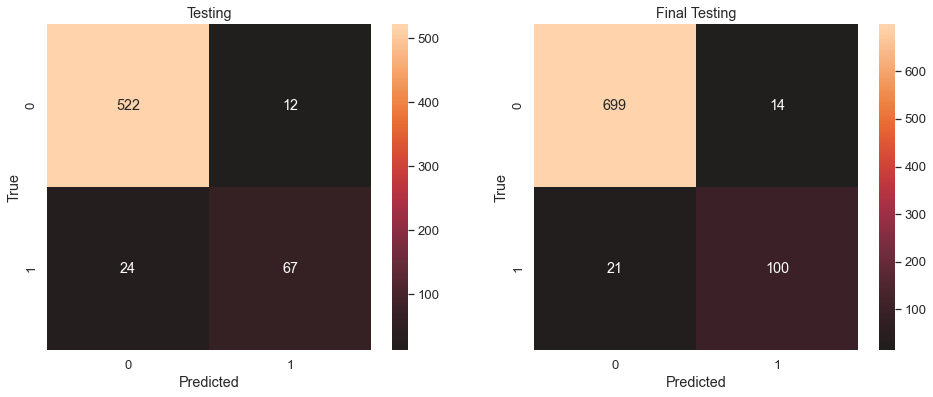

In [11]:
# output confusion matrix
confmat([y_test, t_y], [test_pred, pred], ["Testing", "Final Testing"])

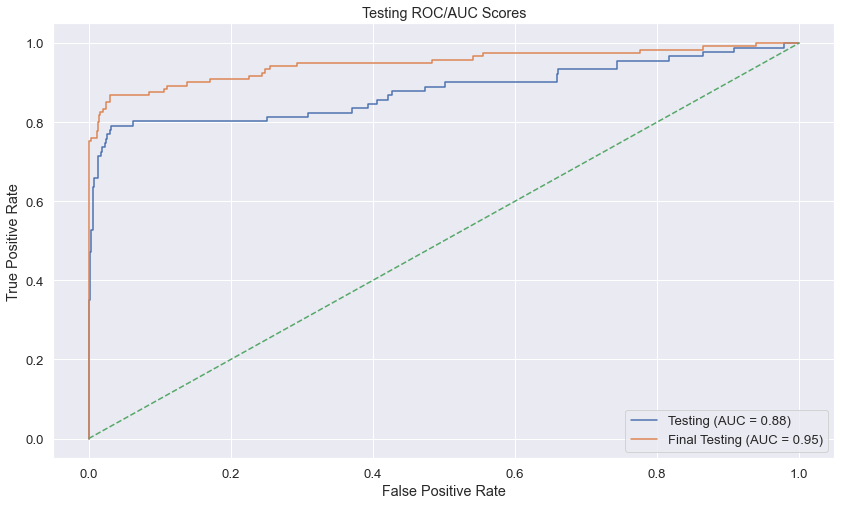

In [12]:
# output roc_auc curve
fig, ax = plt.subplots(figsize=(14, 8))

plot_roc_curve(search, X_test, y_test, name="Testing", ax=ax)
plot_roc_curve(search, t_X, t_y, name="Final Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Testing ROC/AUC Scores")
plt.show()

From our final testing, we see our classifier performs consistently meaning we have not over fitted our model to our training data. Looking at our scores, we do have a relatively low recall, however with an accuracy of 95%, and high f1_score it is negligible. We'll next look into doing an XGBoosted classifier on our data and identify if there are any benefits.

In [13]:
# store our classifier and our feature selector
with open("storage/gb-clf.pickle", "wb") as f:
    pickle.dump(search.best_estimator_, f)
with open("storage/feat-select.pickle", "wb") as f:
    pickle.dump(selector, f)